# Example Preprocessing Flow
- Calculate the target as % change between sucessive raw 'close' values
- Calculate moving averages (feature engineering)
- Represent the input X as a time series (data_to_supervised function)
- Train-test split and visualize

In [1]:
%load_ext autoreload
%autoreload 2
p = print

import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

from crypr.build import truncate, calc_target, calc_volume_ma, data_to_supervised, save_preprocessing_output
from crypr.util import get_project_path

coin = 'BTC'
data_path = os.path.join(get_project_path(), 'data', 'raw', coin + '.csv')

In [2]:
data = pd.read_csv(data_path, index_col=0)
p(data.shape)
data.head()

(5999, 8)


,volumeto,volumefrom,open,high,close,low,time,timestamp
0,6935520.93,1096.93,6314.14,6322.24,6313.66,6290.84,1530471600,2018-07-01 21:00:00
1,24714923.33,3879.19,6313.94,6378.28,6347.37,6298.49,1530475200,2018-07-01 22:00:00
2,9517750.88,1496.49,6347.37,6359.64,6355.81,6331.35,1530478800,2018-07-01 23:00:00
3,12533312.19,1965.11,6355.81,6371.16,6355.41,6346.47,1530482400,2018-07-02 00:00:00
4,13213908.33,2074.03,6355.41,6371.17,6339.04,6337.97,1530486000,2018-07-02 01:00:00


In [3]:
MOVING_AVERAGE_LAGS = [6, 12, 24, 48, 72]
TARGET = 'close'
Tx = 72
Ty = 1
TEST_SIZE = 0.05

,volumeto,volumefrom,open,high,close,low,target,vt_ma6,vf_ma6,vt_ma12,vf_ma12,vt_ma24,vf_ma24,vt_ma48,vf_ma48,vt_ma72,vf_ma72
71,13007702.37,1938.10,6677.90,6698.74,6674.83,6663.81,-0.045374,2.443024e+07,3635.216667,1.989071e+07,2991.421667,1.873332e+07,2840.874167,1.603799e+07,2457.995625,1.707555e+07,2636.003333
72,9378691.92,1399.77,6674.92,6688.86,6687.70,6671.52,0.192814,1.353682e+07,2016.126667,1.990098e+07,2989.329167,1.811250e+07,2746.238750,1.568359e+07,2401.441667,1.710948e+07,2640.209444
73,8424503.46,1254.90,6687.78,6696.86,6693.25,6686.64,0.082988,1.125509e+07,1677.520000,1.792497e+07,2684.321667,1.797735e+07,2725.278333,1.565157e+07,2393.615000,1.688322e+07,2603.760972
74,11276851.07,1681.92,6693.36,6697.32,6694.09,6673.00,0.012550,1.123341e+07,1674.920000,1.763622e+07,2636.394167,1.801105e+07,2729.809583,1.561371e+07,2384.546042,1.690765e+07,2606.336389
75,27926930.49,4202.29,6694.09,6697.69,6598.38,6562.33,-1.429769,1.342175e+07,2007.793333,1.922109e+07,2873.504167,1.729543e+07,2617.797917,1.588542e+07,2422.118542,1.712146e+07,2637.408333


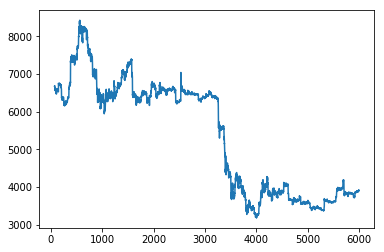

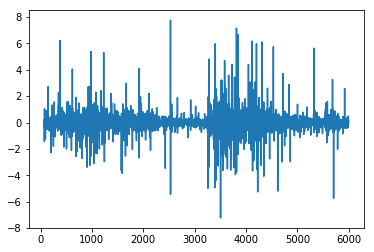

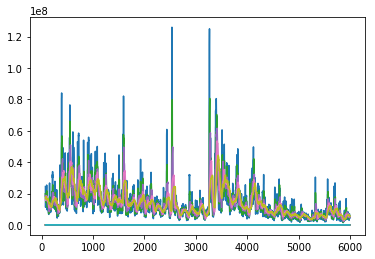

In [4]:
df = data \
    .drop(['time', 'timestamp'], axis=1) \
    .pipe(calc_target, TARGET)\
    .pipe(calc_volume_ma, MOVING_AVERAGE_LAGS)\
    .dropna(how='any', axis=0)
    
plt.figure(); plt.plot(df.close)
plt.figure(); plt.plot(df.target)
plt.figure(); plt.plot(df.filter(regex='v(t|f)'))
df.head()

In [5]:
N_FEATURES = len(df.columns)
N_FEATURES

17

In [6]:
X, y = data_to_supervised(input_df=df, Tx=Tx, Ty=Ty)
X.head()

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1)
143,13007702.37,1938.10,6677.90,6698.74,6674.83,6663.81,-0.045374,2.443024e+07,3635.216667,1.989071e+07,...,1.127572e+07,1713.281667,8.984999e+06,1362.789167,9.462649e+06,1433.027500,1.176674e+07,1789.942083,1.347986e+07,2042.300278
144,9378691.92,1399.77,6674.92,6688.86,6687.70,6671.52,0.192814,1.353682e+07,2016.126667,1.990098e+07,...,9.744978e+06,1481.570000,8.991674e+06,1364.466667,8.517821e+06,1289.817500,1.108382e+07,1684.964167,1.339104e+07,2029.368611
145,8424503.46,1254.90,6687.78,6696.86,6693.25,6686.64,0.082988,1.125509e+07,1677.520000,1.792497e+07,...,8.338396e+06,1266.540000,8.918546e+06,1353.785000,8.440196e+06,1278.243333,1.084223e+07,1647.623333,1.334990e+07,2023.472639
146,11276851.07,1681.92,6693.36,6697.32,6694.09,6673.00,0.012550,1.123341e+07,1674.920000,1.763622e+07,...,8.216904e+06,1250.025000,9.514413e+06,1445.685833,8.599417e+06,1303.322917,1.088818e+07,1654.636875,1.341289e+07,2033.546944
147,27926930.49,4202.29,6694.09,6697.69,6598.38,6562.33,-1.429769,1.342175e+07,2007.793333,1.922109e+07,...,7.977636e+06,1214.376667,9.550916e+06,1451.797500,8.613844e+06,1305.853333,1.086104e+07,1650.345417,1.335362e+07,2025.028333


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=False)
p('Train shape: ', X_train.shape)
p('Test shape: ', X_test.shape)

Train shape:  (5563, 1224)
Test shape:  (293, 1224)


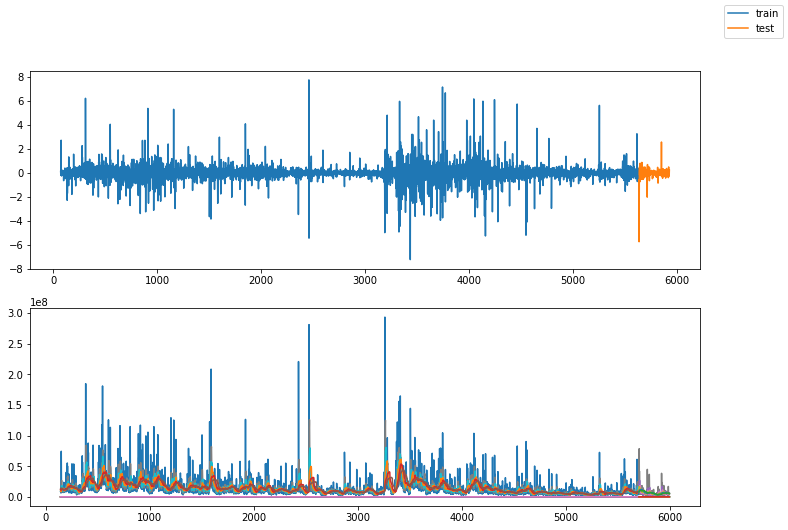

In [8]:
fig, ax = plt.subplots(2, figsize=(12, 8))

ax[0].plot(y_train, label='train')
ax[0].plot(y_test, label='test')

ax[1].plot(X_train.iloc[:,-N_FEATURES:])
ax[1].plot(X_test.iloc[:,-N_FEATURES:])
fig.legend()
plt.show()